In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from tqdm import tqdm
import os
import glob
import random
import xml.etree.ElementTree as ET
from PIL import Image

### Dataset preparation


In [2]:
IMAGE_DIR = "images"                 # Directory containing PNG images
XML_DIR = "annotations"              # Directory containing XML annotations
OUTPUT_DIR = "cnn_dataset"           # Directory to save the prepared dataset

In [3]:
# Extract unique color classes from XML annotations
color_classes = set()
for xml_file in glob.glob(os.path.join(XML_DIR, "*.xml")):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for obj in root.findall('object'):
        color = obj.find('color').text
        if color:
            color_classes.add(color)

color_classes = sorted(list(color_classes))

print(f"Found {len(color_classes)} unique brick classes: {color_classes}")

# Create directories for each color class
for color in color_classes:
    os.makedirs(os.path.join(OUTPUT_DIR, 'train', color), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'test', color), exist_ok=True) 
print(f"Successfully created directories for each color class in {OUTPUT_DIR}/train and {OUTPUT_DIR}/test.")

Found 40 unique brick classes: ['m0', 'm1', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm2', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25', 'm26', 'm27', 'm28', 'm29', 'm3', 'm30', 'm31', 'm32', 'm33', 'm34', 'm35', 'm36', 'm37', 'm38', 'm39', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9']
Successfully created directories for each color class in cnn_dataset/train and cnn_dataset/test.


**Note:** If you already have the data set, skip next 2 cells. If you want to generate yourself I would suggest starting with less amount of images or rewriting the function provided below to multithreading.


In [ ]:
# Change this to multithreading if possible (one one thread it took 12h to run half of the dataset lmao)
def extract_bricks_from_image(file_id, dataset_type):
    try:
        tree = ET.parse(os.path.join(XML_DIR, f"{file_id}.xml"))
        root = tree.getroot()
        
        for obj in root.findall('object'):
            try:
                # Get color
                color_class = obj.find('color').text
                if not color_class:
                    continue
                
                # Get bounding box coordinates
                bndbox = obj.find('bndbox')
                xmin = float(bndbox.find('xmin').text)
                ymin = float(bndbox.find('ymin').text)
                xmax = float(bndbox.find('xmax').text)
                ymax = float(bndbox.find('ymax').text)
                
                # Load the image
                img_path = os.path.join(IMAGE_DIR, f"{file_id}.png")
                if not os.path.exists(img_path):
                    continue
                    
                img = Image.open(img_path)
                image_width, image_height = img.size
                
                # Ensure coordinates are within image bounds
                xmin = max(0, int(xmin))
                ymin = max(0, int(ymin))
                xmax = min(image_width, int(xmax))
                ymax = min(image_height, int(ymax))
                
                # Check if the box is valid (has positive width and height)
                if xmax <= xmin or ymax <= ymin:
                    continue
                
                # Crop the image to the bounding box
                brick_img = img.crop((xmin, ymin, xmax, ymax))
                
                # Create a unique filename for the brick
                output_filename = f"{file_id}_{xmin}_{ymin}_{xmax}_{ymax}.png"
                output_path = os.path.join(OUTPUT_DIR, dataset_type, color_class, output_filename)
                
                # Save the cropped image
                brick_img.save(output_path)
            except Exception as e:
                print(f"Error processing object in {file_id}: {e}")
    except Exception as e:
        print(f"Error processing file {file_id}: {e}")

In [ ]:
# Don't run this if you already have the dataset
# This will take a lot of time lmao

# Get all image files
image_files = sorted(glob.glob(os.path.join(IMAGE_DIR, "*.png")))
print(f"Found {len(image_files)} image files")

# Randomly split into train and validation sets (80:20)
random.seed(42)  # for reproducibility
random.shuffle(image_files)
split_idx = int(0.8 * len(image_files))
train_images = image_files[:split_idx]
test_images = image_files[split_idx:]

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(test_images)}")

for img_path in train_images:
    file_id = os.path.splitext(os.path.basename(img_path))[0]
    extract_bricks_from_image(file_id, 'train')

for img_path in test_images:
    file_id = os.path.splitext(os.path.basename(img_path))[0]
    extract_bricks_from_image(file_id, 'test')

print("Dataset preparation complete!")

### Model training


In [4]:
# I used this notebook as a reference for creating this model: 
# https://github.com/deepsense-ai/Keras-PyTorch-AvP-transfer-learning/blob/master/PyTorch-ResNet50.ipynb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, device

('2.7.0+cu118', device(type='cuda', index=0))

In [11]:
# Create transorms for data augmentation and normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

# Create data loaders with transforms
image_datasets = {
    'train': 
    datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'train'), data_transforms['train']),
    'test': 
    datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'test'), data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True, num_workers=4),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=False, num_workers=4),
    'test_shuffled':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=True, num_workers=4)
}

In [6]:
# Create a ResNet50 model and put it on the GPU
model = models.resnet50().to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, len(color_classes))).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
def train_model(model, criterion, optimizer, epochs=500, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        torch.cuda.empty_cache()

        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(dataloaders['train'], desc=f'Epoch {epoch+1}/{epochs} - training (batches)'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(image_datasets['train'])
        epoch_acc = running_corrects.float() / len(image_datasets['train'])
        print('train loss: {:.4f}, acc: {:.4f}'.format(epoch_loss.item(), epoch_acc.item()))

        # Testing
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['test'], desc=f'Epoch {epoch+1}/{epochs} - validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            val_loss = running_loss / len(image_datasets['test'])
            val_acc = running_corrects.float() / len(image_datasets['test'])
            print(f'val loss: {val_loss.item():.4f}, acc: {val_acc.item():.4f}')
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = deepcopy(model.state_dict())
                print(f"New best validation loss: {best_val_loss.item():.4f}")
            else:
                patience_counter += 1
                print(f"Early stopping counter: {patience_counter}/{patience}")
                
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        if epoch % 10 == 0 and epoch > 0:
            torch.save(model.state_dict(), "models/color_cnn.pt")
            print(f"Saved model at epoch {epoch}")


    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

In [7]:
# Train the model and save the weights

state_dict = torch.load('models/color_cnn.pt')
model.load_state_dict(state_dict)
print("Loaded model weights from file.")

# model_trained = train_model(model, criterion, optimizer)
# torch.save(model_trained.state_dict(), 'models/color_cnn.pt')

Loaded model weights from file.


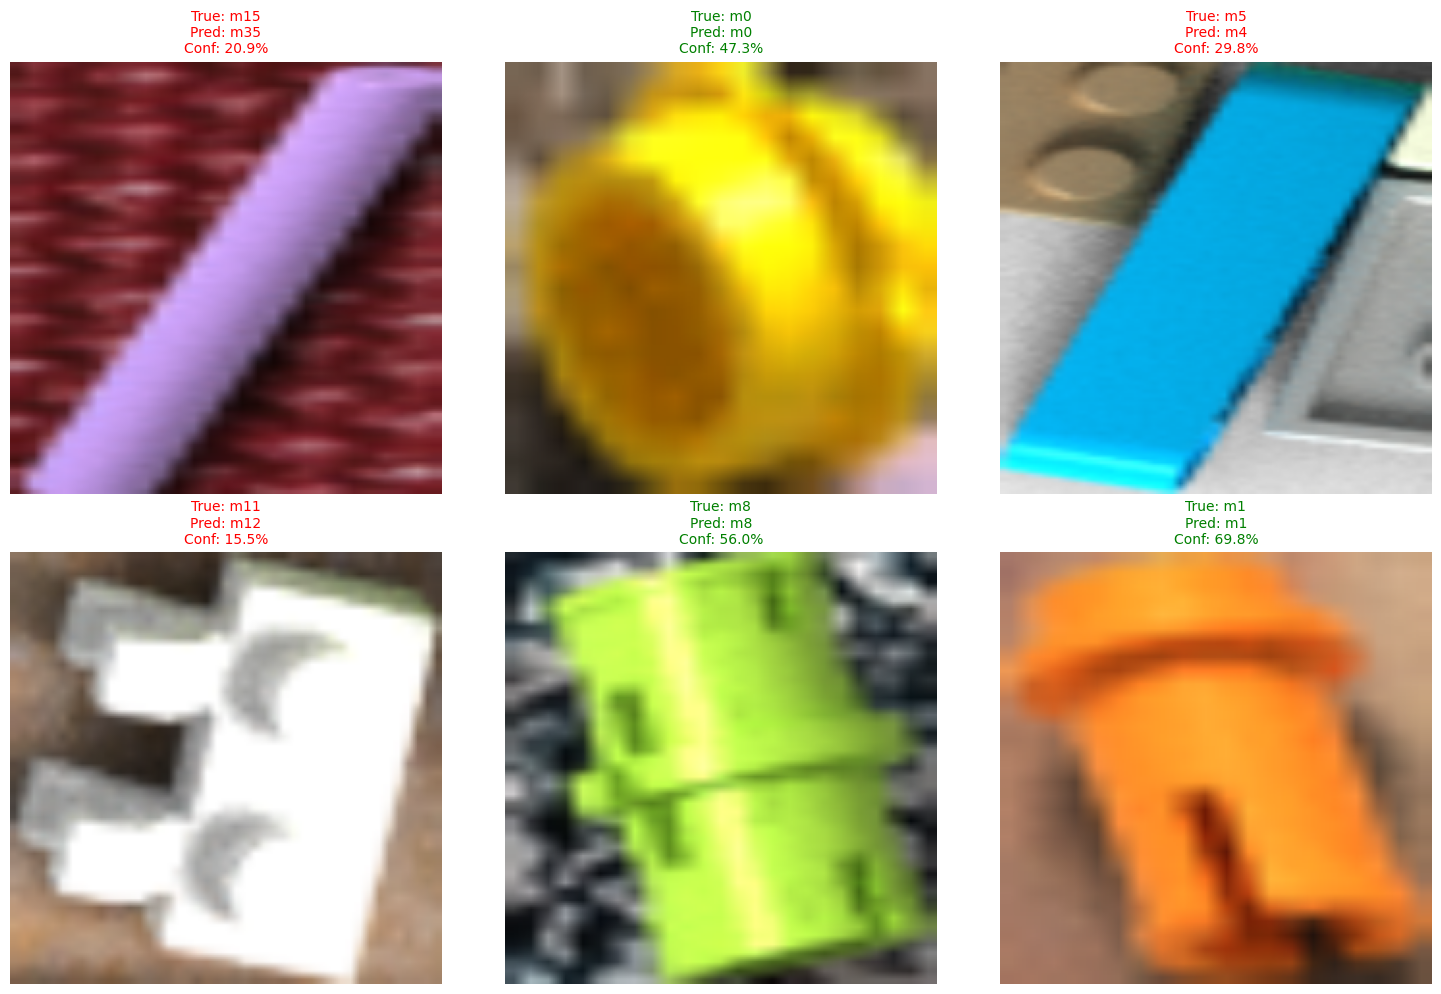

In [12]:
import matplotlib.pyplot as plt

def test_model_on_images(model, num_images=6):
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(dataloaders['test_shuffled'])
    images, labels = next(dataiter)
    
    # Move to device
    images = images.to(device)
    labels = labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    # Move back to CPU for plotting
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()
    
    # Create subplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Denormalize images for display
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    for i in range(min(num_images, len(images))):
        # Denormalize image
        img = images[i].clone()
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        # Plot image
        axes[i].imshow(img_np)
        axes[i].axis('off')
        
        # Get class names
        true_class = color_classes[labels[i]]
        pred_class = color_classes[predicted[i]]
        confidence = probabilities[i][predicted[i]] * 100
        
        # Set title with prediction info
        title_color = 'green' if labels[i] == predicted[i] else 'red'
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%', 
                         color=title_color, fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Test the model
test_model_on_images(model, num_images=6)

**TODO:**

- actually train the model
- add a function to test the model on a single image and plot the results
- build a pipeline with yolo and cnn for full functionality
